# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [1]:
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

<a name=data></a>
## Data

### Ingestion 

In [2]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
print("Parent Directory", parentDir)
# Save the path to all of the datasets
india_cases_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_cases_india.csv")
india_vacc_path = os.path.join(parentDir, "../cleaned_datasets/india/daily_vacc_india.csv")
usa_cases_path = os.path.join(parentDir, "../cleaned_datasets/usa/daily_cases_usa.csv")
usa_vacc_path = os.path.join(parentDir, "../cleaned_datasets/usa/vacc_usa.csv")

# Quick check to make sure the path exists
print("Path:", india_cases_path)
print("Exists:", os.path.exists(india_cases_path))

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True


In [86]:
# Load the data as a pandas dataframe
india_cases_df = pd.read_csv(india_cases_path)
india_vacc_df =  pd.read_csv(india_vacc_path)

usa_cases_df = pd.read_csv(usa_cases_path)
usa_vacc_df = pd.read_csv(usa_vacc_path)

# Visualize the datasets
print('India Cases:\n',india_cases_df.head(),'\n')
print('India Vacc:\n',india_vacc_df.head(),'\n')

print('USA Cases:\n',usa_cases_df.head(),'\n')
print('USA Vacc:\n',usa_vacc_df.head(),'\n')

India Cases:
    Unnamed: 0        Date  Confirmed  Deaths  Recovered  Active
0           0  2020-01-30        1.0     0.0        0.0     0.0
1           1  2020-01-31        0.0     0.0        0.0     0.0
2           2  2020-02-01        0.0     0.0        0.0     0.0
3           3  2020-02-02        1.0     0.0        0.0     0.0
4           4  2020-02-03        1.0     0.0        0.0     0.0 

India Vacc:
    Updated On  Total_Doses  First_Dose  Second_Dose
0  2021-01-16          NaN         NaN          NaN
1  2021-01-17      20656.0     20656.0          0.0
2  2021-01-18      81690.0     81690.0          0.0
3  2021-01-19     192152.0    192152.0          0.0
4  2021-01-20     111510.0    111510.0          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-14    26713.0  2305.0     6484.0
1  2020-04-15    29380.0  2478.0     6093.0
2  2020-04-16    31542.0  4616.0     5234.0
3  2020-04-17    32022.0  3879.0     5904.0
4  2020-04-18    32502.0  1859.0    13591

### Pre-Processing

### Multivariate

In [87]:
india_cases_multi_df = india_cases_df[["Date","Confirmed","Deaths","Recovered","Active"]]

### Univariate 

In [88]:
# Select only the Confirmed column for univariate analysis
# Selecting from the first index because the 0th index is NaN
india_cases_df_sliced = india_cases_df[["Confirmed"]][1:]
usa_cases_df_sliced = usa_cases_df[["Confirmed"]][1:]

# Visualize the datasets
print('India Cases:\n',india_cases_df_sliced.head(),'\n')
print('USA Cases:\n',usa_cases_df_sliced.head(),'\n')

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    29380.0
2    31542.0
3    32022.0
4    32502.0
5    26588.0 



In [89]:
# Normalize the data
india_cases_mean = india_cases_df_sliced.mean()
india_cases_std = india_cases_df_sliced.std()

usa_cases_mean = usa_cases_df_sliced.mean()
usa_cases_std = usa_cases_df_sliced.std()


india_cases_normalized_df = (india_cases_df_sliced-india_cases_mean)/india_cases_std
usa_cases_normalized_df = (usa_cases_df_sliced-usa_cases_mean)/usa_cases_std

# Visualize the datasets
print('India Cases:\n',india_cases_normalized_df.head(),'\n')
print('USA Cases:\n',usa_cases_normalized_df.head(),'\n')

India Cases:
    Confirmed
1  -0.687995
2  -0.687995
3  -0.687983
4  -0.687983
5  -0.687995 

USA Cases:
    Confirmed
1  -0.759976
2  -0.727837
3  -0.720702
4  -0.713566
5  -0.801480 



In [90]:
# Create train test splits
india_cases_train, india_cases_test = train_test_split(india_cases_normalized_df, test_size=0.2, shuffle=False)
india_vacc_train, india_vacc_test = train_test_split(india_vacc_df, test_size=0.2, shuffle=False)

usa_cases_train, usa_cases_test = train_test_split(usa_cases_normalized_df, test_size=0.2, shuffle=False)
usa_vacc_train, usa_vacc_test = train_test_split(usa_vacc_df, test_size=0.2, shuffle=False)

# Visualize splits
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
      Confirmed
1    -0.687995
2    -0.687995
3    -0.687983
4    -0.687983
5    -0.687995
..         ...
492   0.750239
493   0.576535
494   0.398886
495   0.475509
496   0.486403

[496 rows x 1 columns] 

USA Cases:
      Confirmed
1    -0.759976
2    -0.727837
3    -0.720702
4    -0.713566
5    -0.801480
..         ...
432  -1.130479
433  -1.022988
434  -1.037824
435  -1.003589
436  -0.992157

[436 rows x 1 columns] 



In [8]:
# Convert to numpy array
india_cases_train, india_cases_test = india_cases_train.to_numpy().flatten(), india_cases_test.to_numpy()
usa_cases_train, usa_cases_test = usa_cases_train.to_numpy().flatten(), usa_cases_test.to_numpy()

# Visualize outputs
print('India Cases:\n',india_cases_train,'\n')
print('USA Cases:\n',usa_cases_train,'\n')

India Cases:
 [-6.87995117e-01 -6.87995117e-01 -6.87982552e-01 -6.87982552e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01
 -6.87995117e-01 -6.87995117e-01 -6.87995117e-01 -6.87969986e-01
 -6.87995117e-01 -6.87706113e-01 -6.87969986e-01 -6.87982552e-01
 -6.87957421e-01 -6.87932290e-01 -6.87944855e-01 -6.87831767e-01
 -6.87919725e-01 -6.87856898e-01 -6.87882028e-01 -6.87743809e-01
 -6.87856898e-01 -6.87919725e-01 -6.87706113e-01 -6.87819202e-01
 -6.87517632e-01 -6.87366848e-01 -6.86914494e-01 -6.87165802e-01
 -6.86700882e-01 -6.87530198e-01 -6.86474705e-01 -6.87115540e-01
 -6.85984655e-01 -6.86738578e-01 -6.87530198e-01 -6.85142775e-01
 -6.8616057

In [9]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
# choose a number of time steps
n_steps = 3
# split into samples
india_cases_train_X, india_cases_train_y = split_sequence(india_cases_train, n_steps)
india_cases_test_X, india_cases_test_y = split_sequence(india_cases_test, n_steps)
usa_cases_train_X, usa_cases_train_y = split_sequence(usa_cases_train, n_steps)
usa_cases_test_X, usa_cases_test_y = split_sequence(usa_cases_test, n_steps)

# summarize the data
for i in range(0,5):
    print(india_cases_train_X[i], india_cases_train_y[i])
print()
# summarize the data
for i in range(0,5):
    print(usa_cases_train_X[i], usa_cases_train_y[i])

[-0.68799512 -0.68799512 -0.68798255] -0.687982551549953
[-0.68799512 -0.68798255 -0.68798255] -0.6879951169346211
[-0.68798255 -0.68798255 -0.68799512] -0.6879951169346211
[-0.68798255 -0.68799512 -0.68799512] -0.6879951169346211
[-0.68799512 -0.68799512 -0.68799512] -0.6879951169346211

[-0.75997589 -0.72783707 -0.72070172] -0.7135663621434901
[-0.72783707 -0.72070172 -0.71356636] -0.8014798602697645
[-0.72070172 -0.71356636 -0.80147986] -0.8206709874393655
[-0.71356636 -0.80147986 -0.82067099] -0.7796129756326746
[-0.80147986 -0.82067099 -0.77961298] -0.7701734979001443


In [11]:
# Reshape the data into [samples, timesteps, features]
# univariate
n_features = 1

india_cases_train_X = india_cases_train_X.reshape((india_cases_train_X.shape[0], 
                                                   india_cases_train_X.shape[1], n_features))
india_cases_test_X = india_cases_test_X.reshape((india_cases_test_X.shape[0], 
                                                 india_cases_test_X.shape[1], n_features))

usa_cases_train_X = usa_cases_train_X.reshape((usa_cases_train_X.shape[0], 
                                                   usa_cases_train_X.shape[1], n_features))
usa_cases_test_X = usa_cases_test_X.reshape((usa_cases_test_X.shape[0], 
                                                   usa_cases_test_X.shape[1], n_features))

# Visualize outputs
print('India Cases:\n',india_cases_train_X,'\n')
print('USA Cases:\n',usa_cases_train_X,'\n')

India Cases:
 [[[-0.68799512]
  [-0.68799512]
  [-0.68798255]]

 [[-0.68799512]
  [-0.68798255]
  [-0.68798255]]

 [[-0.68798255]
  [-0.68798255]
  [-0.68799512]]

 ...

 [[ 0.82649813]
  [ 0.75023881]
  [ 0.57653493]]

 [[ 0.75023881]
  [ 0.57653493]
  [ 0.39888553]]

 [[ 0.57653493]
  [ 0.39888553]
  [ 0.47550924]]] 

USA Cases:
 [[[-0.75997589]
  [-0.72783707]
  [-0.72070172]]

 [[-0.72783707]
  [-0.72070172]
  [-0.71356636]]

 [[-0.72070172]
  [-0.71356636]
  [-0.80147986]]

 ...

 [[-1.07058673]
  [-1.13047911]
  [-1.02298798]]

 [[-1.13047911]
  [-1.02298798]
  [-1.03782357]]

 [[-1.02298798]
  [-1.03782357]
  [-1.00358874]]] 



<a name=model></a>
## Model 

In [12]:
# Imports for model components
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanAbsolutePercentageError, MeanAbsoluteError
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Univariate non-stacked -- Rolling

In [13]:
# Define the model
def build_univariate_non_stacked(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(1))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

### Univariate non-stacked -- Long-Term

In [14]:
# Define the model
def build_univariate_non_stacked_long(optimizer="adam", lstm_nparams=100, n_steps=3, n_features=1):
    model_uni = Sequential()
    model_uni.add(LSTM(lstm_nparams, activation='relu', input_shape=(n_steps, n_features)))
    model_uni.add(Dense(10))
    model_uni.compile(optimizer=optimizer,loss='mae', metrics=["mae"])
    model_uni.summary()
    return model_uni

#### Grid Search

In [15]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_non_stacked, verbose=1)

In [16]:
# Defining parameters for the gridserach
param_grid = {
#     'epochs': [10,100,300,],
    'lstm_nparams':[15,50],
#     'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

In [17]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
#                     scoring="neg_mean_absolute_error",
)

In [18]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
13/13 [==============================] - 0s 1ms/step - loss: 0.6758 - mae: 0.6758
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
______________

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
13/13 [==============================] - 0s 2ms/step - loss: 0.6172 - mae: 0.6172
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
________

In [19]:
# Writing the gridsearch results to file
file1 = open("univariate_non_stacked_india.txt", "w")
file1.write("mean,stdev,pram")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f,%f,%r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

In [20]:
sorted(grid_result.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_lstm_nparams',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [21]:
grid_result.cv_results_['split2_train_score']

array([-0.73189408, -0.68911481])

### Univariate stacked -- Rolling

In [22]:
# Define the model
def build_univariate_stacked(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(1))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

### Univariate stacked -- Long-Term

In [25]:
# Define the model
def build_univariate_stacked_long(optimizer="adam",lstm_nparams_l1=100, lstm_nparams_l2=150, n_steps=3, n_features=1):
    model_uni_stacked = Sequential()
    model_uni_stacked.add(LSTM(lstm_nparams_l1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model_uni_stacked.add(LSTM(lstm_nparams_l2, activation='relu'))
    model_uni_stacked.add(Dense(10))
    model_uni_stacked.compile(optimizer=optimizer,loss='mae')
    model_uni_stacked.summary()
    return model_uni_stacked

#### Grid Search

In [26]:
# Using KerasClassifier wrapper 
keras_estimator = KerasRegressor(build_fn=build_univariate_stacked, verbose=1)

In [24]:
# Defining parameters for the gridserach
param_grid = {
    'epochs': [10,100,300,],
    'lstm_nparams_l1':[15,50,100,150],
    'lstm_nparams_l2':[15,50,100,150],
    'n_steps': [3, 6, 15],
#     'optimizer': ['RMSprop','Adam','Adamax','sgd']
}

kfold_splits = 5

KeyboardInterrupt: 

In [ ]:
# Defining GridSearch
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=-1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,
                    scoring="neg_mean_absolute_error",
)

In [ ]:
# Fitting GridSearch
grid_result = grid.fit(india_cases_train_X, india_cases_train_y, )

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# Writing the gridsearch results to file
file1 = open("univariate_stacked_india.txt", "w")
file1.write("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
file1.write("\n")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    file1.write("%f (%f) with: %r" % (mean, stdev, param))
    file1.write("\n")
file1.close()

## Multivariate 

In [27]:
# Define the model
model_uni = Sequential()
model_uni.add(LSTM(150, activation='relu', input_shape=(n_steps, n_features)))
model_uni.add(Dense(1))
model_uni.compile(optimizer='adam',loss='mae')
model_uni.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


<a name=train></a>
## Train 

In [28]:
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [29]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [30]:
# Define all of the LSTM models
model_uni_non_stacked_india = build_univariate_non_stacked()
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_long_india = build_univariate_non_stacked_long()
model_uni_non_stacked_long_usa = build_univariate_non_stacked_long()
model_uni_stacked_india = build_univariate_stacked()
model_uni_stacked_usa = build_univariate_stacked()
model_uni_stacked_long_india = build_univariate_stacked_long()
model_uni_stacked_long_usa = build_univariate_stacked()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_14"

In [31]:
models_india = [model_uni_non_stacked_india,model_uni_non_stacked_long_india,model_uni_stacked_india ,model_uni_stacked_long_india]
models_usa = [model_uni_non_stacked_usa,model_uni_non_stacked_long_usa,model_uni_stacked_usa ,model_uni_stacked_long_usa]

In [32]:
models_india_trained = []
for m in models_india:
    models_india_trained.append(train_models(m,india_cases_train_X,india_cases_train_y,india_cases_test_X,india_cases_test_y))

Epoch 1/300
16/16 [==============================] - 1s 26ms/step - loss: 0.5932 - mae: 0.5932 - val_loss: 0.1303 - val_mae: 0.1303
Epoch 2/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4032 - mae: 0.4032 - val_loss: 0.0650 - val_mae: 0.0650
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 0.1436 - mae: 0.1436 - val_loss: 0.0978 - val_mae: 0.0978
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0976 - mae: 0.0976 - val_loss: 0.0755 - val_mae: 0.0755
Epoch 5/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0930 - mae: 0.0930 - val_loss: 0.0761 - val_mae: 0.0761
Epoch 6/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0933 - mae: 0.0933 - val_loss: 0.0715 - val_mae: 0.0715
Epoch 7/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0909 - mae: 0.0909 - val_loss: 0.0709 - val_mae: 0.0709
Epoch 8/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0904 - 

16/16 [==============================] - 0s 6ms/step - loss: 0.0683 - mae: 0.0683 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 64/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0632 - val_mae: 0.0632
Epoch 65/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0714 - mae: 0.0714 - val_loss: 0.0675 - val_mae: 0.0675
Epoch 66/300
 1/16 [>.............................] - ETA: 0s - loss: 0.0460 - mae: 0.0460

KeyboardInterrupt: 

In [ ]:
for m in models_usa:
    train_models(m,usa_cases_train_X,usa_cases_train_y,usa_cases_test_X,usa_cases_test_y)

### Univariate non-stacked -- Rolling

In [33]:
# Fit the model
model_uni_non_stacked_india = build_univariate_non_stacked()
model_uni_non_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_india.save('univar_non_stack_rolling_india.h5')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 28ms/step - loss: 0.6326 - mae: 0.6326 - val_loss: 0.1394 - val_mae: 0.1394
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.4930 - mae: 0.4930 - val_loss: 0.0727 - val_mae: 0.0727
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.3130 - mae: 0.3130 - val_loss: 0.0642 - val_mae: 0.0642
Epoch 4/300
16/16 [==============================] - 0s 6ms/step - loss: 0.1444 - mae: 0.1444 - val_loss: 0.0976 - va

16/16 [==============================] - 0s 6ms/step - loss: 0.0712 - mae: 0.0712 - val_loss: 0.0688 - val_mae: 0.0688
Epoch 58/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0695 - mae: 0.0695 - val_loss: 0.0665 - val_mae: 0.0665
Epoch 59/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0717 - mae: 0.0717 - val_loss: 0.0647 - val_mae: 0.0647
Epoch 60/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0701 - mae: 0.0701 - val_loss: 0.0665 - val_mae: 0.0665
Epoch 61/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0671 - mae: 0.0671 - val_loss: 0.0655 - val_mae: 0.0655
Epoch 62/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0674 - mae: 0.0674 - val_loss: 0.0709 - val_mae: 0.0709
Epoch 63/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0684 - mae: 0.0684 - val_loss: 0.0671 - val_mae: 0.0671
Epoch 64/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0699 - mae: 0

16/16 [==============================] - 0s 6ms/step - loss: 0.0729 - mae: 0.0729 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 120/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0669 - mae: 0.0669 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 121/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0662 - mae: 0.0662 - val_loss: 0.0678 - val_mae: 0.0678
Epoch 122/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0662 - val_mae: 0.0662
Epoch 123/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0663 - mae: 0.0663 - val_loss: 0.0681 - val_mae: 0.0681
Epoch 124/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0662 - mae: 0.0662 - val_loss: 0.0643 - val_mae: 0.0643
Epoch 125/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0663 - mae: 0.0663 - val_loss: 0.0657 - val_mae: 0.0657
Epoch 126/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0676 -

Epoch 181/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0642 - mae: 0.0642 - val_loss: 0.0673 - val_mae: 0.0673
Epoch 182/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.0641 - val_mae: 0.0641
Epoch 183/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0670 - mae: 0.0670 - val_loss: 0.0641 - val_mae: 0.0641
Epoch 184/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0668 - mae: 0.0668 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0629 - mae: 0.0629 - val_loss: 0.0618 - val_mae: 0.0618
Epoch 187/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0642 - mae: 0.0642 - val_loss: 0.0682 - val_mae: 0.0682
Epoch 188/300
16/16 [==============================] - 0s 5ms/step - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0613 - mae: 0.0613 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 243/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0611 - mae: 0.0611 - val_loss: 0.0621 - val_mae: 0.0621
Epoch 244/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0627 - val_mae: 0.0627
Epoch 245/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0603 - val_mae: 0.0603
Epoch 246/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0632 - val_mae: 0.0632
Epoch 247/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0601 - mae: 0.0601 - val_loss: 0.0597 - val_mae: 0.0597
Epoch 248/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0606 - mae: 0.0606 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 249/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0610 -

In [34]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 34ms/step - loss: 0.6899 - mae: 0.6899 - val_loss: 0.9140 - val_mae: 0.9140
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.5531 - mae: 0.5531 - val_loss: 0.8629 - val_mae: 0.8629
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.3721 - mae: 0.3721 - val_loss: 0.8158 - val_mae: 0.8158
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.2333 - mae: 0.2333 - val_loss: 0.8312 - va

14/14 [==============================] - 0s 5ms/step - loss: 0.1541 - mae: 0.1541 - val_loss: 0.7951 - val_mae: 0.7951
Epoch 58/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1563 - mae: 0.1563 - val_loss: 0.7936 - val_mae: 0.7936
Epoch 59/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1528 - mae: 0.1528 - val_loss: 0.7994 - val_mae: 0.7994
Epoch 60/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1518 - mae: 0.1518 - val_loss: 0.7980 - val_mae: 0.7980
Epoch 61/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1542 - mae: 0.1542 - val_loss: 0.7962 - val_mae: 0.7962
Epoch 62/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1521 - mae: 0.1521 - val_loss: 0.7929 - val_mae: 0.7929
Epoch 63/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1508 - mae: 0.1508 - val_loss: 0.7987 - val_mae: 0.7987
Epoch 64/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1506 - mae: 0

14/14 [==============================] - 0s 6ms/step - loss: 0.1445 - mae: 0.1445 - val_loss: 0.8071 - val_mae: 0.8071
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1427 - mae: 0.1427 - val_loss: 0.8119 - val_mae: 0.8119
Epoch 121/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1437 - mae: 0.1437 - val_loss: 0.8092 - val_mae: 0.8092
Epoch 122/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1445 - mae: 0.1445 - val_loss: 0.8083 - val_mae: 0.8083
Epoch 123/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1413 - mae: 0.1413 - val_loss: 0.8070 - val_mae: 0.8070
Epoch 124/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1431 - mae: 0.1431 - val_loss: 0.8153 - val_mae: 0.8153
Epoch 125/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1409 - mae: 0.1409 - val_loss: 0.8139 - val_mae: 0.8139
Epoch 126/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1408 -

Epoch 181/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1351 - mae: 0.1351 - val_loss: 0.8171 - val_mae: 0.8171
Epoch 182/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1406 - mae: 0.1406 - val_loss: 0.8244 - val_mae: 0.8244
Epoch 183/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1379 - mae: 0.1379 - val_loss: 0.8321 - val_mae: 0.8321
Epoch 184/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1383 - mae: 0.1383 - val_loss: 0.8333 - val_mae: 0.8333
Epoch 185/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1367 - mae: 0.1367 - val_loss: 0.8242 - val_mae: 0.8242
Epoch 186/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1389 - mae: 0.1389 - val_loss: 0.8180 - val_mae: 0.8180
Epoch 187/300
14/14 [==============================] - 0s 7ms/step - loss: 0.1404 - mae: 0.1404 - val_loss: 0.8168 - val_mae: 0.8168
Epoch 188/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 6ms/step - loss: 0.1314 - mae: 0.1314 - val_loss: 0.7842 - val_mae: 0.7842
Epoch 243/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1361 - mae: 0.1361 - val_loss: 0.7819 - val_mae: 0.7819
Epoch 244/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1337 - mae: 0.1337 - val_loss: 0.7710 - val_mae: 0.7710
Epoch 245/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1320 - mae: 0.1320 - val_loss: 0.7721 - val_mae: 0.7721
Epoch 246/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1300 - mae: 0.1300 - val_loss: 0.7675 - val_mae: 0.7675
Epoch 247/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.7672 - val_mae: 0.7672
Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1305 - mae: 0.1305 - val_loss: 0.7685 - val_mae: 0.7685
Epoch 249/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1312 -

### Univariate non-stacked -- Long-Term

In [35]:
# Fit the model
model_uni_non_stacked_long_india = build_univariate_non_stacked_long()
model_uni_non_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_long_india.save('univar_non_stacked_long_term_india.h5')

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1010      
Total params: 41,810
Trainable params: 41,810
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 1s 34ms/step - loss: 0.6765 - mae: 0.6765 - val_loss: 0.1954 - val_mae: 0.1954
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.6057 - mae: 0.6057 - val_loss: 0.1442 - val_mae: 0.1442
Epoch 3/300
16/16 [==============================] - 0s 6ms/step - loss: 0.4644 - mae: 0.4644 - val_loss: 0.0907 - val_mae: 0.0907
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2119 - mae: 0.2119 - val_loss: 0.0843 - va

16/16 [==============================] - 0s 5ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0721 - val_mae: 0.0721
Epoch 58/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0743 - mae: 0.0743 - val_loss: 0.0705 - val_mae: 0.0705
Epoch 59/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0659 - val_mae: 0.0659
Epoch 60/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0725 - mae: 0.0725 - val_loss: 0.0696 - val_mae: 0.0696
Epoch 61/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0735 - mae: 0.0735 - val_loss: 0.0695 - val_mae: 0.0695
Epoch 62/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0764 - mae: 0.0764 - val_loss: 0.0654 - val_mae: 0.0654
Epoch 63/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0735 - mae: 0.0735 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 64/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0728 - mae: 0

16/16 [==============================] - 0s 5ms/step - loss: 0.0681 - mae: 0.0681 - val_loss: 0.0694 - val_mae: 0.0694
Epoch 120/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0672 - mae: 0.0672 - val_loss: 0.0654 - val_mae: 0.0654
Epoch 121/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0687 - val_mae: 0.0687
Epoch 122/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0666 - val_mae: 0.0666
Epoch 123/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0687 - mae: 0.0687 - val_loss: 0.0664 - val_mae: 0.0664
Epoch 124/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0669 - mae: 0.0669 - val_loss: 0.0652 - val_mae: 0.0652
Epoch 125/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0667 - mae: 0.0667 - val_loss: 0.0676 - val_mae: 0.0676
Epoch 126/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0663 -

Epoch 181/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0658 - mae: 0.0658 - val_loss: 0.0684 - val_mae: 0.0684
Epoch 182/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0651 - mae: 0.0651 - val_loss: 0.0682 - val_mae: 0.0682
Epoch 183/300
16/16 [==============================] - 0s 7ms/step - loss: 0.0651 - mae: 0.0651 - val_loss: 0.0649 - val_mae: 0.0649
Epoch 184/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.0659 - val_mae: 0.0659
Epoch 185/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0661 - mae: 0.0661 - val_loss: 0.0688 - val_mae: 0.0688
Epoch 186/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0655 - mae: 0.0655 - val_loss: 0.0648 - val_mae: 0.0648
Epoch 187/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0649 - mae: 0.0649 - val_loss: 0.0684 - val_mae: 0.0684
Epoch 188/300
16/16 [==============================] - 0s 5ms/step - 

16/16 [==============================] - 0s 5ms/step - loss: 0.0636 - mae: 0.0636 - val_loss: 0.0661 - val_mae: 0.0661
Epoch 243/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0624 - mae: 0.0624 - val_loss: 0.0680 - val_mae: 0.0680
Epoch 244/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0651 - mae: 0.0651 - val_loss: 0.0663 - val_mae: 0.0663
Epoch 245/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0650 - mae: 0.0650 - val_loss: 0.0663 - val_mae: 0.0663
Epoch 246/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0649 - mae: 0.0649 - val_loss: 0.0649 - val_mae: 0.0649
Epoch 247/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.0654 - val_mae: 0.0654
Epoch 248/300
16/16 [==============================] - 0s 5ms/step - loss: 0.0660 - mae: 0.0660 - val_loss: 0.0640 - val_mae: 0.0640
Epoch 249/300
16/16 [==============================] - 0s 6ms/step - loss: 0.0675 -

In [36]:
# Fit the model
model_uni_non_stacked_usa = build_univariate_non_stacked()
model_uni_non_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_non_stacked_usa.save('univar_non_stack_rolling_usa.h5')

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 1s 33ms/step - loss: 0.7508 - mae: 0.7508 - val_loss: 0.9370 - val_mae: 0.9370
Epoch 2/300
14/14 [==============================] - 0s 6ms/step - loss: 0.6274 - mae: 0.6274 - val_loss: 0.8947 - val_mae: 0.8947
Epoch 3/300
14/14 [==============================] - 0s 6ms/step - loss: 0.4844 - mae: 0.4844 - val_loss: 0.8389 - val_mae: 0.8389
Epoch 4/300
14/14 [==============================] - 0s 6ms/step - loss: 0.2997 - mae: 0.2997 - val_loss: 0.8326 - va

14/14 [==============================] - 0s 6ms/step - loss: 0.1552 - mae: 0.1552 - val_loss: 0.8031 - val_mae: 0.8031
Epoch 58/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1573 - mae: 0.1573 - val_loss: 0.8013 - val_mae: 0.8013
Epoch 59/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1560 - mae: 0.1560 - val_loss: 0.8056 - val_mae: 0.8056
Epoch 60/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1556 - mae: 0.1556 - val_loss: 0.7946 - val_mae: 0.7946
Epoch 61/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.8033 - val_mae: 0.8033
Epoch 62/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1517 - mae: 0.1517 - val_loss: 0.8031 - val_mae: 0.8031
Epoch 63/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1553 - mae: 0.1553 - val_loss: 0.8075 - val_mae: 0.8075
Epoch 64/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1509 - mae: 0

14/14 [==============================] - 0s 6ms/step - loss: 0.1481 - mae: 0.1481 - val_loss: 0.8006 - val_mae: 0.8006
Epoch 120/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1447 - mae: 0.1447 - val_loss: 0.8020 - val_mae: 0.8020
Epoch 121/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1437 - mae: 0.1437 - val_loss: 0.8056 - val_mae: 0.8056
Epoch 122/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1441 - mae: 0.1441 - val_loss: 0.8069 - val_mae: 0.8069
Epoch 123/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1429 - mae: 0.1429 - val_loss: 0.8046 - val_mae: 0.8046
Epoch 124/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1440 - mae: 0.1440 - val_loss: 0.8105 - val_mae: 0.8105
Epoch 125/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1450 - mae: 0.1450 - val_loss: 0.8080 - val_mae: 0.8080
Epoch 126/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1431 -

Epoch 181/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.8394 - val_mae: 0.8394
Epoch 182/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1405 - mae: 0.1405 - val_loss: 0.8421 - val_mae: 0.8421
Epoch 183/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1366 - mae: 0.1366 - val_loss: 0.8374 - val_mae: 0.8374
Epoch 184/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1378 - mae: 0.1378 - val_loss: 0.8407 - val_mae: 0.8407
Epoch 185/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1365 - mae: 0.1365 - val_loss: 0.8440 - val_mae: 0.8440
Epoch 186/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1357 - mae: 0.1357 - val_loss: 0.8439 - val_mae: 0.8439
Epoch 187/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1365 - mae: 0.1365 - val_loss: 0.8432 - val_mae: 0.8432
Epoch 188/300
14/14 [==============================] - 0s 6ms/step - 

14/14 [==============================] - 0s 5ms/step - loss: 0.1313 - mae: 0.1313 - val_loss: 0.8281 - val_mae: 0.8281
Epoch 243/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1315 - mae: 0.1315 - val_loss: 0.8283 - val_mae: 0.8283
Epoch 244/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1319 - mae: 0.1319 - val_loss: 0.8227 - val_mae: 0.8227
Epoch 245/300
14/14 [==============================] - 0s 5ms/step - loss: 0.1379 - mae: 0.1379 - val_loss: 0.8226 - val_mae: 0.8226
Epoch 246/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1397 - mae: 0.1397 - val_loss: 0.8195 - val_mae: 0.8195
Epoch 247/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1294 - mae: 0.1294 - val_loss: 0.8178 - val_mae: 0.8178
Epoch 248/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1304 - mae: 0.1304 - val_loss: 0.8252 - val_mae: 0.8252
Epoch 249/300
14/14 [==============================] - 0s 6ms/step - loss: 0.1308 -

### Univariate stacked -- Rolling

In [37]:
# Fit the model
model_uni_stacked_india = build_univariate_stacked()
model_uni_stacked_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_india.save('univar_stacked_rolling_india.h5')

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_29 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 42ms/step - loss: 0.6418 - val_loss: 0.1274
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.3540 - val_loss: 0.0982
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.1403 - val_loss: 0.0798
Epoch 4/300
16/16 [==============================] - 0s 9ms/step - loss: 0.113

16/16 [==============================] - 0s 9ms/step - loss: 0.0726 - val_loss: 0.0618
Epoch 73/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0740 - val_loss: 0.0669
Epoch 74/300
16/16 [==============================] - 0s 8ms/step - loss: 0.0706 - val_loss: 0.0677
Epoch 75/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0740 - val_loss: 0.0723
Epoch 76/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0705 - val_loss: 0.0657
Epoch 77/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0682 - val_loss: 0.0675
Epoch 78/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0706 - val_loss: 0.0654
Epoch 79/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0681 - val_loss: 0.0643
Epoch 80/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0695 - val_loss: 0.0661
Epoch 81/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0665 - val_loss: 0.0665
Epoch 82/30

16/16 [==============================] - 0s 9ms/step - loss: 0.0631 - val_loss: 0.0623
Epoch 154/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0662 - val_loss: 0.0658
Epoch 155/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0648 - val_loss: 0.0653
Epoch 156/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0673 - val_loss: 0.0651
Epoch 157/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0658 - val_loss: 0.0619
Epoch 158/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0649 - val_loss: 0.0619
Epoch 159/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0655 - val_loss: 0.0589
Epoch 160/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0723 - val_loss: 0.0656
Epoch 161/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0649 - val_loss: 0.0671
Epoch 162/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0674 - val_loss: 0.06

Epoch 234/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0647 - val_loss: 0.0603
Epoch 235/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0664 - val_loss: 0.0600
Epoch 236/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0661 - val_loss: 0.0658
Epoch 237/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0624 - val_loss: 0.0648
Epoch 238/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0656 - val_loss: 0.0663
Epoch 239/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0632 - val_loss: 0.0615
Epoch 240/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0616 - val_loss: 0.0642
Epoch 241/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0646 - val_loss: 0.0612
Epoch 242/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0660 - val_loss: 0.0626
Epoch 243/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0664 - val_

In [38]:
# Fit the model
model_uni_stacked_usa = build_univariate_stacked()
model_uni_stacked_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_usa.save('univar_stacked_rolling_usa.h5')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_31 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 47ms/step - loss: 0.7113 - val_loss: 0.9293
Epoch 2/300
14/14 [==============================] - 0s 10ms/step - loss: 0.5190 - val_loss: 0.8393
Epoch 3/300
14/14 [==============================] - 0s 9ms/step - loss: 0.2507 - val_loss: 0.8112
Epoch 4/300
14/14 [==============================] - 0s 10ms/step - loss: 0.20

Epoch 72/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1487 - val_loss: 0.7606
Epoch 73/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1478 - val_loss: 0.7557
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1463 - val_loss: 0.7557
Epoch 75/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1499 - val_loss: 0.7508
Epoch 76/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1570 - val_loss: 0.7596
Epoch 77/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1505 - val_loss: 0.7512
Epoch 78/300
14/14 [==============================] - 0s 8ms/step - loss: 0.1480 - val_loss: 0.7592
Epoch 79/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1493 - val_loss: 0.7524
Epoch 80/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1458 - val_loss: 0.7493
Epoch 81/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1446 - val_loss: 0.74

Epoch 153/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1395 - val_loss: 0.7759
Epoch 154/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1441 - val_loss: 0.7733
Epoch 155/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1373 - val_loss: 0.7646
Epoch 156/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.7655
Epoch 157/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.7861
Epoch 158/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1364 - val_loss: 0.7587
Epoch 159/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1376 - val_loss: 0.7635
Epoch 160/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1339 - val_loss: 0.7787
Epoch 161/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1366 - val_loss: 0.7601
Epoch 162/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1360 

14/14 [==============================] - 0s 10ms/step - loss: 0.1242 - val_loss: 0.8125
Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1255 - val_loss: 0.8160
Epoch 235/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1236 - val_loss: 0.8294
Epoch 236/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1244 - val_loss: 0.8219
Epoch 237/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1260 - val_loss: 0.8184
Epoch 238/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1240 - val_loss: 0.8195
Epoch 239/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1228 - val_loss: 0.8283
Epoch 240/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1293 - val_loss: 0.8252
Epoch 241/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1331 - val_loss: 0.8333
Epoch 242/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1234 - val_loss: 0.83

### Univariate stacked -- Long-Term

In [39]:
# Fit the model
model_uni_stacked_long_india = build_univariate_stacked_long()
model_uni_stacked_long_india.fit(india_cases_train_X,
          india_cases_train_y, 
          validation_data=(india_cases_test_X, india_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_india.save('univar_stacked_long_term.h5')

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_33 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1510      
Total params: 192,910
Trainable params: 192,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
16/16 [==============================] - 2s 44ms/step - loss: 0.6761 - val_loss: 0.1991
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.5416 - val_loss: 0.1126
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 0.2125 - val_loss: 0.0908
Epoch 4/300
16/16 [==============================] - 0s 10ms/step - loss: 0.1

16/16 [==============================] - 0s 10ms/step - loss: 0.0760 - val_loss: 0.0689
Epoch 72/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0798 - val_loss: 0.0637
Epoch 73/300
16/16 [==============================] - 0s 11ms/step - loss: 0.0703 - val_loss: 0.0670
Epoch 74/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0735 - val_loss: 0.0633
Epoch 75/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0670 - val_loss: 0.0675
Epoch 76/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0679 - val_loss: 0.0699
Epoch 77/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0717 - val_loss: 0.0687
Epoch 78/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0738 - val_loss: 0.0680
Epoch 79/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0672 - val_loss: 0.0661
Epoch 80/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0701 - val_loss: 0.0676
Epo

Epoch 152/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0704 - val_loss: 0.0669
Epoch 153/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0654 - val_loss: 0.0686
Epoch 154/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0704 - val_loss: 0.0657
Epoch 155/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0803 - val_loss: 0.0634
Epoch 156/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0748 - val_loss: 0.0645
Epoch 157/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0692 - val_loss: 0.0730
Epoch 158/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0758 - val_loss: 0.0637
Epoch 159/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0719 - val_loss: 0.0709
Epoch 160/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0686 - val_loss: 0.0708
Epoch 161/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0697 - v

16/16 [==============================] - 0s 10ms/step - loss: 0.0662 - val_loss: 0.0696
Epoch 233/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0659 - val_loss: 0.0671
Epoch 234/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0648 - val_loss: 0.0679
Epoch 235/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0696 - val_loss: 0.0711
Epoch 236/300
16/16 [==============================] - 0s 11ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 237/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0651 - val_loss: 0.0756
Epoch 238/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0655
Epoch 239/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0682 - val_loss: 0.0621
Epoch 240/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0661 - val_loss: 0.0657
Epoch 241/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0677 - val_loss: 0.0697

In [40]:
# Fit the model
model_uni_stacked_long_usa = build_univariate_stacked()
model_uni_stacked_long_usa.fit(usa_cases_train_X,
          usa_cases_train_y, 
          validation_data=(usa_cases_test_X, usa_cases_test_y),
          epochs=300,
          callbacks=[tensorboard_callback])

model_uni_stacked_long_usa.save('univar_stacked_long_term_usa.h5')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_35 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 151       
Total params: 191,551
Trainable params: 191,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
14/14 [==============================] - 2s 48ms/step - loss: 0.7076 - val_loss: 0.9250
Epoch 2/300
14/14 [==============================] - 0s 10ms/step - loss: 0.5055 - val_loss: 0.8271
Epoch 3/300
14/14 [==============================] - 0s 11ms/step - loss: 0.2594 - val_loss: 0.8063
Epoch 4/300
14/14 [==============================] - 0s 10ms/step - loss: 0.2

Epoch 72/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1481 - val_loss: 0.7780
Epoch 73/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1485 - val_loss: 0.7775
Epoch 74/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1518 - val_loss: 0.7784
Epoch 75/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1514 - val_loss: 0.7744
Epoch 76/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1476 - val_loss: 0.7752
Epoch 77/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1524 - val_loss: 0.7683
Epoch 78/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1504 - val_loss: 0.7736
Epoch 79/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1523 - val_loss: 0.7768
Epoch 80/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1488 - val_loss: 0.7740
Epoch 81/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1573 - val_loss:

14/14 [==============================] - 0s 10ms/step - loss: 0.1365 - val_loss: 0.7835
Epoch 154/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1334 - val_loss: 0.7764
Epoch 155/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1372 - val_loss: 0.7759
Epoch 156/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1394 - val_loss: 0.7741
Epoch 157/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.7875
Epoch 158/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1362 - val_loss: 0.7757
Epoch 159/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1345 - val_loss: 0.7702
Epoch 160/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1358 - val_loss: 0.7771
Epoch 161/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1340 - val_loss: 0.7802
Epoch 162/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1343 - val_loss: 0.78

Epoch 234/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1267 - val_loss: 0.8063
Epoch 235/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1226 - val_loss: 0.8241
Epoch 236/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1294 - val_loss: 0.8081
Epoch 237/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1217 - val_loss: 0.8069
Epoch 238/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1220 - val_loss: 0.8208
Epoch 239/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1269 - val_loss: 0.8097
Epoch 240/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1280 - val_loss: 0.7981
Epoch 241/300
14/14 [==============================] - 0s 9ms/step - loss: 0.1276 - val_loss: 0.8140
Epoch 242/300
14/14 [==============================] - 0s 11ms/step - loss: 0.1294 - val_loss: 0.8050
Epoch 243/300
14/14 [==============================] - 0s 10ms/step - loss: 0.1259 - val

<a name=predict></a>
## Predict

In [41]:
india_cases_test_X.shape

(122, 3, 1)

In [42]:
india_cases_test.shape

(125, 1)

In [43]:
models_india = [model_uni_non_stacked_india,model_uni_non_stacked_long_india,model_uni_stacked_india ,model_uni_stacked_long_india]
models_india
models_usa = [model_uni_non_stacked_usa,model_uni_non_stacked_long_usa,model_uni_stacked_usa ,model_uni_stacked_long_usa]

In [44]:
def make_predictions(test_X, model):
    x_input = np.array(test_X)
    y_hat = model.predict(x_input)
    return()

### Univariate Non Stacked -- Rolling

In [45]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_india.shape)
yhat_uni_non_stacked_india = model_uni_non_stacked_india.predict(x_input_uni_non_stacked_india)
print(yhat_uni_non_stacked_india.shape)

(122, 3, 1)
(122, 1)


In [46]:
# Predictions for usa cases on test dataset
x_input_uni_non_stacked_usa = np.array(usa_cases_test_X)
print(x_input_uni_non_stacked_usa.shape)
yhat_uni_non_stacked_usa = model_uni_non_stacked_usa.predict(x_input_uni_non_stacked_usa)
print(yhat_uni_non_stacked_usa.shape)

(107, 3, 1)
(107, 1)


### Univariate Non Stacked -- Long-Term

In [47]:
# Predictions for india cases on test dataset
x_input_uni_non_stacked_long_india = np.array(india_cases_test_X)
print(x_input_uni_non_stacked_long_india.shape)
yhat_uni_non_stacked_long_india = model_uni_non_stacked_long_india.predict(x_input_uni_non_stacked_long_india)
print(yhat_uni_non_stacked_long_india.shape)

(122, 3, 1)
(122, 10)


In [48]:
# Predictions for usa cases on test dataset
x_input_uni_non_stacked_long_usa = np.array(usa_cases_test_X)
print(x_input_uni_non_stacked_long_usa.shape)
yhat_uni_non_stacked_long_usa = model_uni_non_stacked_long_usa.predict(x_input_uni_non_stacked_long_usa)
print(yhat_uni_non_stacked_long_usa.shape)

(107, 3, 1)
(107, 10)


### Univariate Stacked -- Rolling

In [49]:
# Predictions for india cases on test dataset
x_input_uni_stacked_india = np.array(india_cases_test_X)
print(x_input_uni_stacked_india.shape)
yhat_uni_stacked_india = model_uni_stacked_india.predict(x_input_uni_stacked_india)
print(yhat_uni_stacked_india.shape)

(122, 3, 1)
(122, 1)


In [50]:
# Predictions for usa cases on test dataset
x_input_uni_stacked_usa = np.array(usa_cases_test_X)
print(x_input_uni_stacked_usa.shape)
yhat_uni_stacked_usa = model_uni_stacked_usa.predict(x_input_uni_stacked_usa)
print(yhat_uni_stacked_usa.shape)

(107, 3, 1)
(107, 1)


### Univariate Stacked -- Long-Term

In [51]:
# Predictions for india cases on test dataset
x_input_uni_stacked_long_india = np.array(india_cases_test_X)
print(x_input_uni_stacked_long_india.shape)
yhat_uni_stacked_long_india = model_uni_stacked_long_india.predict(x_input_uni_stacked_long_india)
print(yhat_uni_stacked_long_india.shape)

(122, 3, 1)
(122, 10)


In [52]:
# Predictions for usa cases on test dataset
x_input_uni_stacked_long_usa = np.array(usa_cases_test_X)
print(x_input_uni_stacked_long_usa.shape)
yhat_uni_stacked_long_usa = model_uni_stacked_long_usa.predict(x_input_uni_stacked_long_usa)
print(yhat_uni_stacked_long_usa.shape)

(107, 3, 1)
(107, 1)


## Evaluate

### Univariate Non Stacked -- Rolling

#### India

In [53]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

38.38218

In [54]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_india).numpy()

0.060563628

#### USA

In [55]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_non_stacked_usa).numpy()

149.54387

In [56]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_non_stacked_usa).numpy()

0.81220347

### Univariate Non Stacked -- Long-Term

#### India 

In [57]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_non_stacked_long_india).numpy()

42.083134

In [58]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_non_stacked_long_india).numpy()

0.064644784

#### USA 

In [59]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_non_stacked_long_usa).numpy()

100.01093

In [60]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_non_stacked_long_usa).numpy()

0.9629942

### Univariate Stacked -- Rolling

#### India 

In [61]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked_india).numpy()

36.577404

In [62]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked_india).numpy()

0.060939386

#### USA 

In [63]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_stacked_usa).numpy()

173.15631

In [64]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_stacked_usa).numpy()

0.86673874

### Univariate Stacked -- Long-Term

#### India 

In [65]:
mape = MeanAbsolutePercentageError()
mape(india_cases_test_y, yhat_uni_stacked_long_india).numpy()

43.89136

In [66]:
mae = MeanAbsoluteError()
mae(india_cases_test_y, yhat_uni_stacked_long_india).numpy()

0.069019005

#### USA

In [67]:
mape = MeanAbsolutePercentageError()
mape(usa_cases_test_y, yhat_uni_stacked_long_usa).numpy()

158.24854

In [68]:
mae = MeanAbsoluteError()
mae(usa_cases_test_y, yhat_uni_stacked_long_usa).numpy()

0.8376302

## Plots

In [69]:
# Reversing Z-score normalization

casted_mean = india_cases_mean.to_numpy()
casted_std = india_cases_std.to_numpy()

india_cases_test_scaled = (india_cases_std[0]*india_cases_test)+india_cases_mean[0]
india_cases_train_scaled = (india_cases_std[0]*india_cases_train)+india_cases_mean[0]

yhat_uni_non_stacked_india_scaled = (india_cases_std[0]*yhat_uni_non_stacked_india)+india_cases_mean[0]
yhat_uni_non_stacked_long_india_scaled = (india_cases_std[0]*yhat_uni_non_stacked_long_india)+india_cases_mean[0]
yhat_uni_stacked_india_scaled = (india_cases_std[0]*yhat_uni_stacked_india)+india_cases_mean[0]
yhat_uni_stacked_long_india_scaled = (india_cases_std[0]*yhat_uni_stacked_long_india)+india_cases_mean[0]

usa_cases_test_scaled = (usa_cases_std[0]*usa_cases_test)+usa_cases_mean[0]
usa_cases_train_scaled = (usa_cases_std[0]*usa_cases_train)+usa_cases_mean[0]

yhat_uni_non_stacked_usa_scaled = (usa_cases_std[0]*yhat_uni_non_stacked_usa)+usa_cases_mean[0]
yhat_uni_non_stacked_long_usa_scaled = (usa_cases_std[0]*yhat_uni_non_stacked_long_usa)+usa_cases_mean[0]
yhat_uni_stacked_usa_scaled = (usa_cases_std[0]*yhat_uni_stacked_usa)+usa_cases_mean[0]
yhat_uni_stacked_long_usa_scaled = (usa_cases_std[0]*yhat_uni_stacked_long_usa)+usa_cases_mean[0]

print(yhat_uni_non_stacked_india_scaled.size)
print(india_cases_test_scaled.size)

122
125


In [100]:
india_cases_df

,Unnamed: 0,Date,Confirmed,Deaths,Recovered,Active
0,0,2020-01-30,1.0,0.0,0.0,0.0
1,1,2020-01-31,0.0,0.0,0.0,0.0
2,2,2020-02-01,0.0,0.0,0.0,0.0
3,3,2020-02-02,1.0,0.0,0.0,0.0
4,4,2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
617,617,2021-10-08,19740.0,248.0,0.0,0.0
618,618,2021-10-09,18166.0,214.0,0.0,0.0
619,619,2021-10-10,18132.0,193.0,0.0,0.0
620,620,2021-10-11,14313.0,181.0,0.0,0.0


In [112]:
yhat_uni_non_stacked_india_scaled.flatten()

array([82319.664, 78041.805, 72092.63 , 63519.57 , 66580.68 , 63653.82 ,
       62195.85 , 59387.797, 55047.344, 50563.38 , 49906.94 , 52774.855,
       52206.37 , 49790.906, 50140.58 , 47136.043, 43838.46 , 44872.652,
       47586.984, 47055.59 , 45027.145, 43740.71 , 41130.246, 38373.098,
       42454.516, 44999.14 , 44044.715, 43387.164, 42261.938, 39289.227,
       36547.25 , 38628.5  , 41193.164, 40100.773, 39275.53 , 41132.305,
       39440.09 , 37251.32 , 40088.355, 41194.23 , 38926.316, 40808.77 ,
       50303.93 , 45411.18 , 42209.434, 41054.992, 42873.645, 44325.355,
       42564.96 , 42400.43 , 41072.63 , 38592.336, 40684.875, 42429.074,
       44490.504, 40791.64 , 40095.695, 37357.793, 35186.633, 37054.89 ,
       40201.457, 40811.6  , 39801.074, 37778.836, 35438.484, 32922.453,
       34021.445, 35873.   , 37450.94 , 36132.637, 33844.945, 31127.412,
       27593.166, 34326.445, 42740.12 , 44652.402, 46496.66 , 45467.91 ,
       43758.055, 41211.664, 40416.473, 45212.86 , 

In [161]:
india_cases_df['Date']= pd.to_datetime(india_cases_df['Date'])
india_cases_df = india_cases_df.set_index('Date')
india_cases_df['yhat_uni_non_stacked_india_scaled'] = None
india_cases_df['yhat_uni_non_stacked_india_scaled'][499:621] = yhat_uni_non_stacked_india_scaled.flatten()
india_cases_df['yhat_uni_stacked_india_scaled'] = None
india_cases_df['yhat_uni_stacked_india_scaled'][499:621] = yhat_uni_stacked_india_scaled.flatten()
india_cases_df[499:]

KeyError: 'Date'

In [131]:
yhat_uni_non_stacked_usa_scaled.size

107

In [132]:
usa_cases_df

,Date,Confirmed,Deaths,Recovered,yhat_uni_non_stacked_usa_scaled
0,2020-04-14,26713.0,2305.0,6484.0,None
1,2020-04-15,29380.0,2478.0,6093.0,None
2,2020-04-16,31542.0,4616.0,5234.0,None
3,2020-04-17,32022.0,3879.0,5904.0,None
4,2020-04-18,32502.0,1859.0,13591.0,None
...,...,...,...,...,...
542,2021-10-08,131142.0,1837.0,0.0,None
543,2021-10-09,27501.0,279.0,0.0,None
544,2021-10-10,22194.0,255.0,0.0,None
545,2021-10-11,116202.0,1182.0,0.0,None


In [150]:
usa_cases_df = usa_cases_df.set_index('Date')
usa_cases_df['yhat_uni_non_stacked_usa_scaled'] = None
usa_cases_df['yhat_uni_non_stacked_usa_scaled'][440:547] = yhat_uni_non_stacked_usa_scaled.flatten()
usa_cases_df['yhat_uni_stacked_usa_scaled'] = None
usa_cases_df['yhat_uni_stacked_usa_scaled'][440:547] = yhat_uni_stacked_usa_scaled.flatten()
usa_cases_df[436:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Confirmed,Deaths,Recovered,yhat_uni_non_stacked_usa_scaled,yhat_uni_stacked_usa_scaled
Date,,,,,
2021-06-24,13761.0,345.0,0.0,None,None
2021-06-25,24324.0,499.0,0.0,None,None
2021-06-26,8639.0,151.0,0.0,None,None
2021-06-27,4251.0,78.0,0.0,None,None
2021-06-28,14574.0,155.0,0.0,10727.9,11138.3
...,...,...,...,...,...
2021-10-08,131142.0,1837.0,0.0,94481.5,95005.9
2021-10-09,27501.0,279.0,0.0,121245,123040
2021-10-10,22194.0,255.0,0.0,70732,97753.5


In [151]:
def plot_fore_test(test, fore, title):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)

    ax.plot(test, color='blue', label='Test')
    ax.plot(fore, color='red', label='Forecast')
    ax.legend(loc='best')
    plt.title(title)
    plt.show()

In [152]:
def plot_train_test_fore(train, test, fore, title='Forecast vs Actuals', ylabel='', xlabel='Date', figpath=None):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fore, label='forecast')
    fig = plt.gcf()
    
    plt.xlabel=xlabel
    plt.ylabel=ylabel

    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    if figpath is not None:
        fig.savefig(figpath, format='eps', bbox_inches='tight')

### Univariate Non Stacked -- Rolling

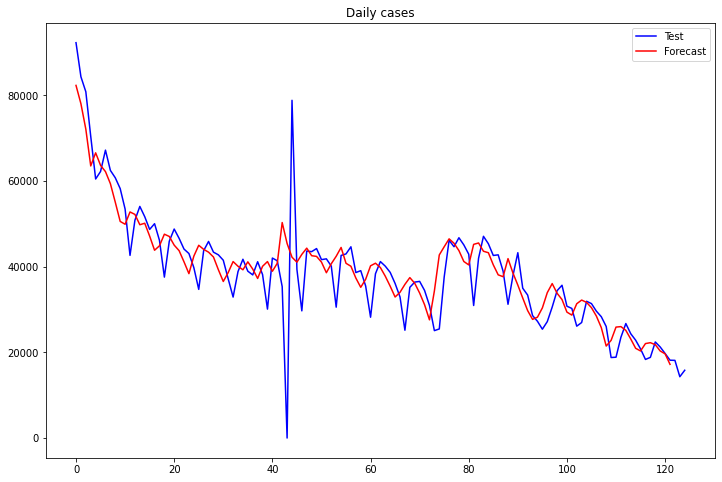

In [153]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked_india_scaled, title='Daily cases')

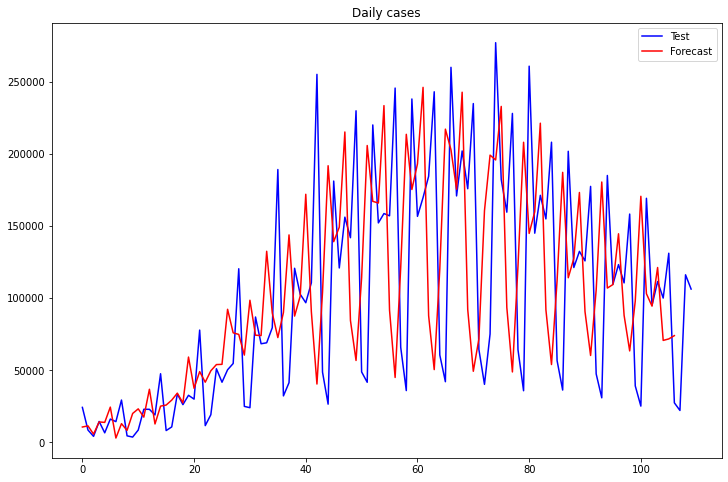

In [154]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_non_stacked_usa_scaled, title='Daily cases')

In [155]:
india_cases_train_scaled.size

496

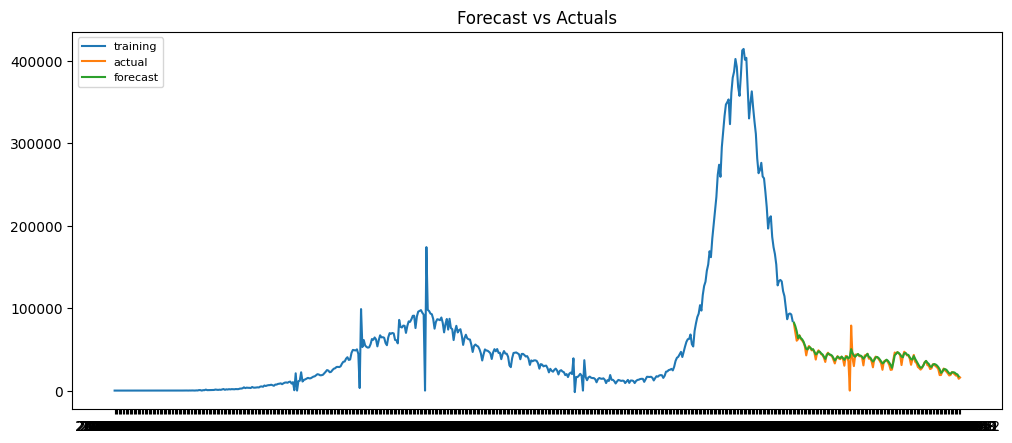

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [156]:
plot_train_test_fore(india_cases_df[['Confirmed']][0:499], india_cases_df[['Confirmed']][499:], india_cases_df[['yhat_uni_non_stacked_india_scaled']],figpath='../../figures/lstm/forecast_vs_actuals_uni_non_stacked_india.eps')

In [157]:
usa_cases_train_scaled.size

436

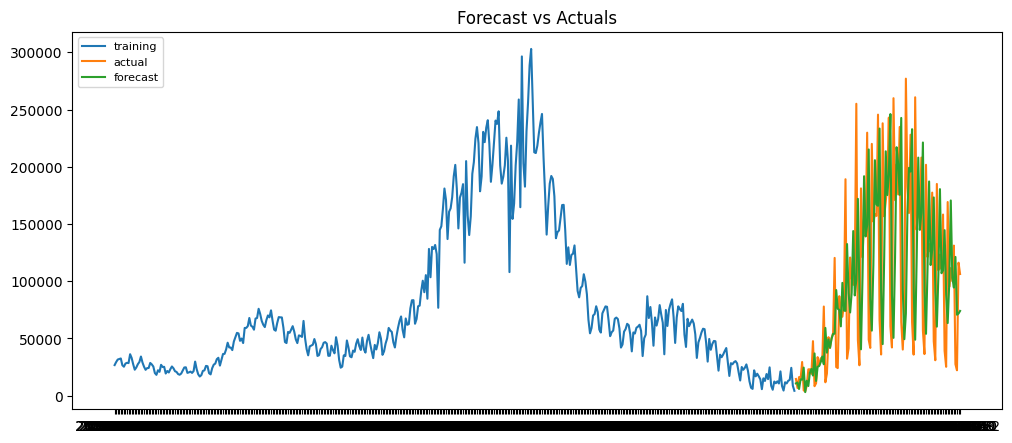

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [158]:
plot_train_test_fore(usa_cases_df[['Confirmed']][0:440], usa_cases_df[['Confirmed']][440:], usa_cases_df[['yhat_uni_non_stacked_usa_scaled']], figpath='../../figures/lstm/forecast_vs_actuals_uni_non_stacked_usa.eps')

### Univariate Non Stacked -- Long-Term

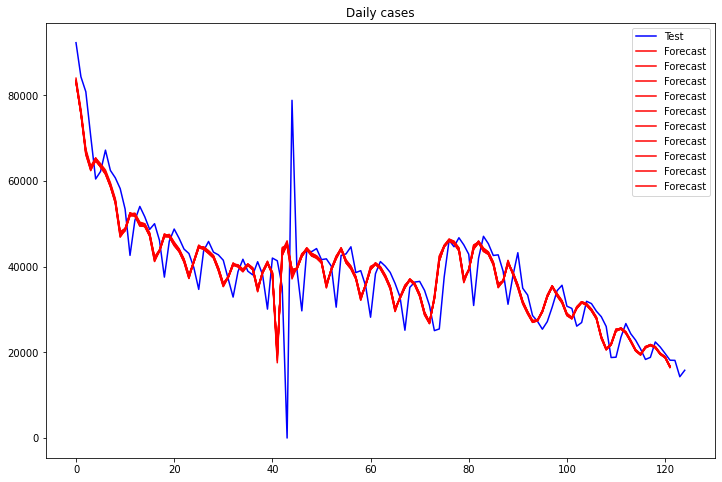

In [159]:
plot_fore_test(india_cases_test_scaled, yhat_uni_non_stacked_long_india_scaled, title='Daily cases')

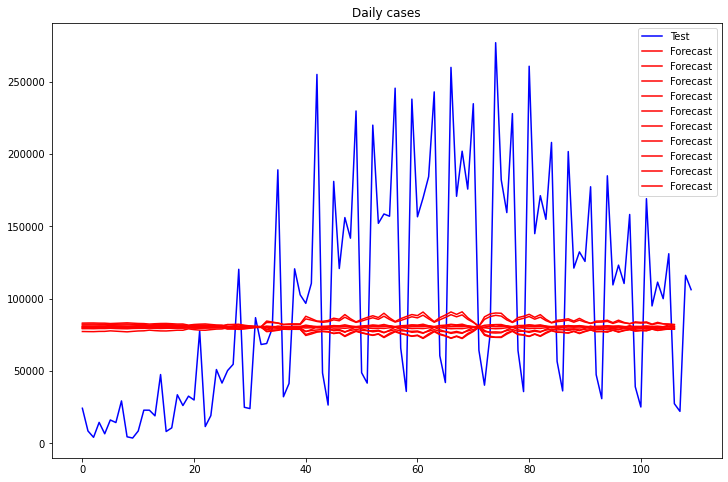

In [160]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_non_stacked_long_usa_scaled, title='Daily cases')

### Univariate Stacked -- Rolling

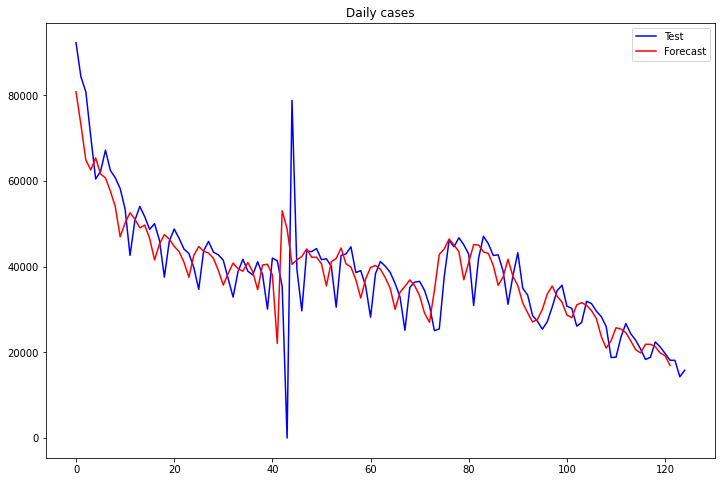

In [73]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked_india_scaled, title='Daily cases')

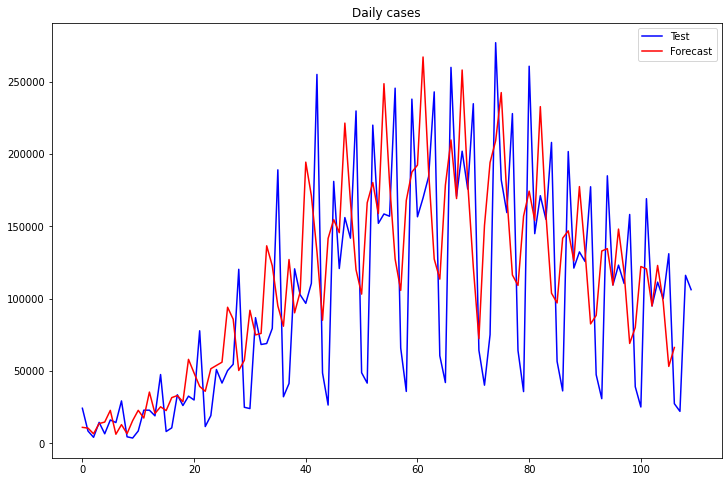

In [74]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_stacked_usa_scaled, title='Daily cases')

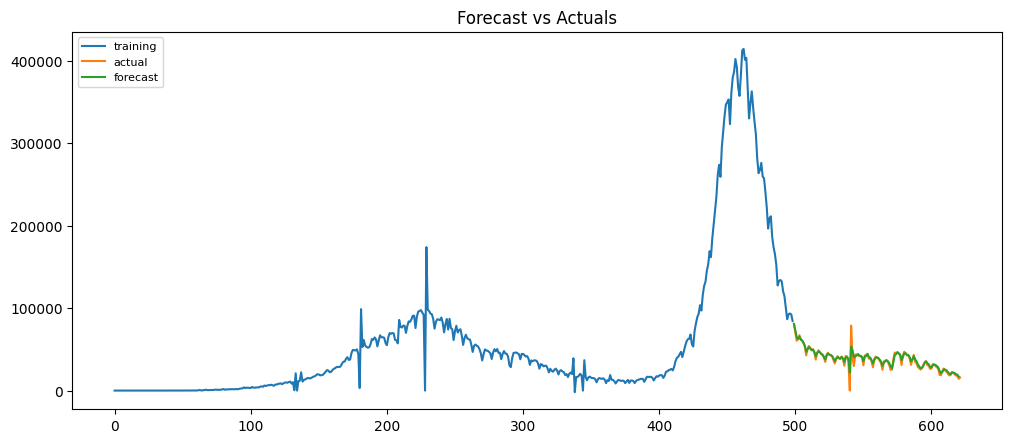

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [145]:
plot_train_test_fore(india_cases_df[['Confirmed']][0:499], india_cases_df[['Confirmed']][499:], india_cases_df[['yhat_uni_stacked_india_scaled']],figpath='../../figures/lstm/forecast_vs_actuals_uni_stacked_india.eps')

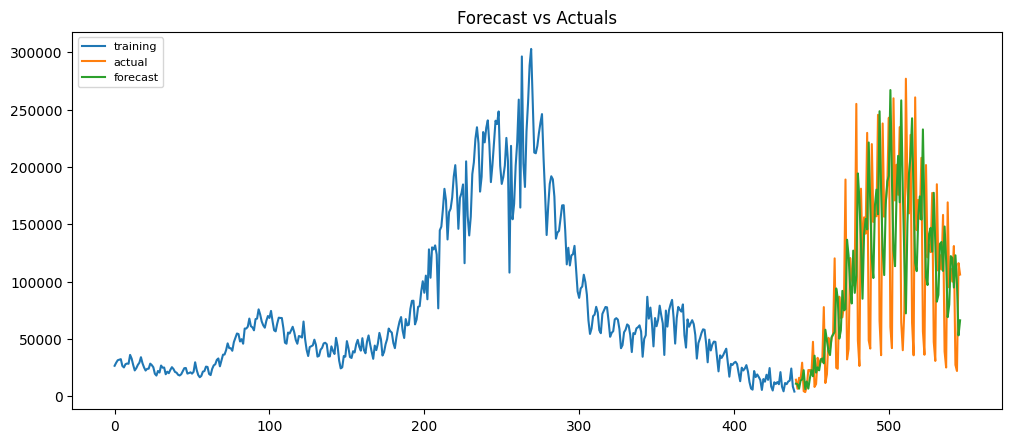

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [146]:
plot_train_test_fore(usa_cases_df[['Confirmed']][0:440], usa_cases_df[['Confirmed']][440:], usa_cases_df[['yhat_uni_stacked_usa_scaled']], figpath='../../figures/lstm/forecast_vs_actuals_uni_stacked_usa.eps')

### Univariate Stacked -- Long-Term

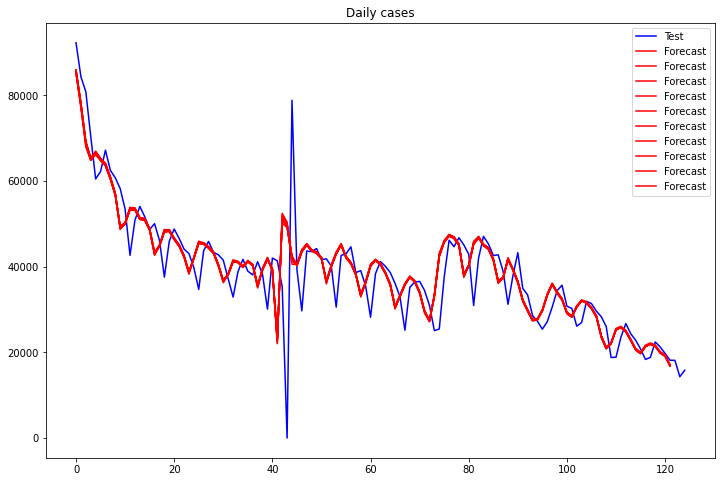

In [147]:
plot_fore_test(india_cases_test_scaled, yhat_uni_stacked_long_india_scaled, title='Daily cases')

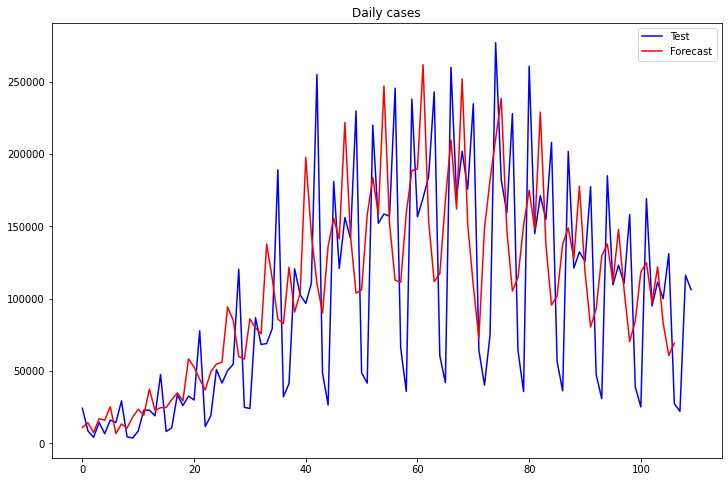

In [148]:
plot_fore_test(usa_cases_test_scaled, yhat_uni_stacked_long_usa_scaled, title='Daily cases')